In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

In [2]:
import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_baseline

The key elements of the TDE metric are a metric -- which defines the detection or characterization criteria for each event -- and a custom slicer -- which defines the locations and lightcurves for the events. The lightcurves are sample lightcurves of two known events at three different redshifts.

The slicer is a UserPointsSlicer, with additional information tied to each slicePoint. A UserSlicePoint lets the user define RA/Dec values for the slicePoints over the sky (the locations of each event). This is then augmented by additional information on *when* the events happen and what the lightcurve looks like (or any other information about each event), tied to each slicePoint. Each slicePoint then represents each event. The slicer is set up by a function related to the metric called something like `generateTdePopSlicer` -- this function read information about how many lightcurves shoudl be simulated and where they should be distributed, sets up the UserPointSlicer with that RA/Dec information, and then adds lightcurve information as appropriate.

The metric then gets the information about the observations at each slicePoint (each RA/Dec value) as well as the slicePoint information related to the lightcurve (such as the time of the peak or the shape of the event, etc) -- the brightness at the time of each observation is generally up to the metric to calculate or interpolate as it will depend on the timing of the observations from the simulation. The metric evaluates the observed points on the lightcurve against its criteria for discovery or characterization, etc. and returns an appropriate value. For some metrics this will be a simple 0/1 (discovered or not) but for other metrics it might be something like how accurately the lightcurve could be fit. 

## Setup the observing strategy database and the TDE slicer

In [3]:
baseline_file = get_baseline()
opsim = os.path.basename(baseline_file).replace('.db','')
opsdb = maf.db.OpsimDatabase(baseline_file)

In [4]:
n_events = 10000 
slicer = maf.mafContrib.generateTdePopSlicer(n_events=n_events)

## Run prepeak, some_color and some_color_pu metric

Light curves are detected by each metric separately, if they pass the following requirements:
 - **prepeak**: at least 2 data points in 2 different filters before the peak of light curve
 - **some_color**: at least 1 data point in $t < t_{peak} - 10$ d, at least 3 data points in 3 different filters in $t < t_{peak} \pm 5$ d, at least 2 data points in 2 different filters in $t_{peak} + 10$ d $< t < t_{peak} + 30$ d 
 - **some_color_pu**: at least 1 point in $t < t_{peak} - 10$ d, at least 1 *u*-band data point and 1 data point in any filter in $t < t_{peak} \pm 5$ d, at least 1 *u*-band data point and 1 data point in any filter in $t_{peak} + 10$ d $< t < t_{peak} + 30$ d

In [5]:
metric = maf.mafContrib.TdePopMetric()
# These summary metrics are now available as 'batches.lightcurveSummary' 
# (i.e. summaryMetrics = maf.lightcurveSummary())
summaryMetrics = [maf.SumMetric(metricName='Total detected'), 
                  maf.CountMetric(metricName='Total lightcurves in footprint'),
                  maf.CountMetric(metricName='Total lightcurves on sky', maskVal=0), 
                  maf.MeanMetric(metricName='Fraction detected in footprint'), 
                  maf.MeanMetric(maskVal=0, metricName='Fraction detected of total')]

In [6]:
bundle = maf.MetricBundle(metric, slicer, None, runName=opsim, summaryMetrics=summaryMetrics)

In [7]:
outDir = 'test_tde'
bdict = {'tde': bundle}
g = maf.MetricBundleGroup(bdict, opsdb, outDir)

In [8]:
g.runAll()

Querying database observations with no constraint for columns ['filter', 'rotSkyPos', 'fieldRA', 'night', 'observationStartMJD', 'fieldDec', 'fiveSigmaDepth'].
Found 2086980 visits
Running:  ['tde']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [9]:
bdict.keys()

dict_keys(['tde', 'TDEsPopMetric__prepeak', 'TDEsPopMetric__some_color', 'TDEsPopMetric__some_color_pu'])

### Plot the outputs

The TDEsPopMetric returns 0 or 1 whether the lightcurve could be detected or not with specified requirements on the number of data points and filters required before the peak, near the peak, and after the peak of the light curve.

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


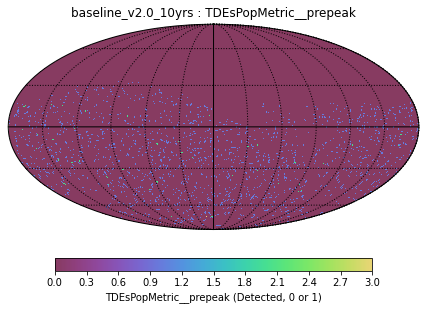

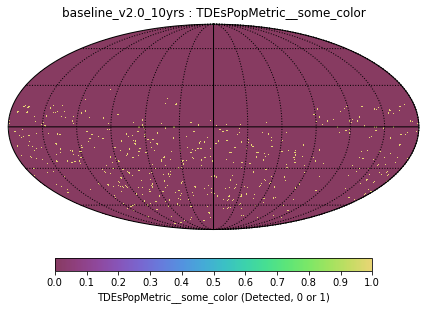

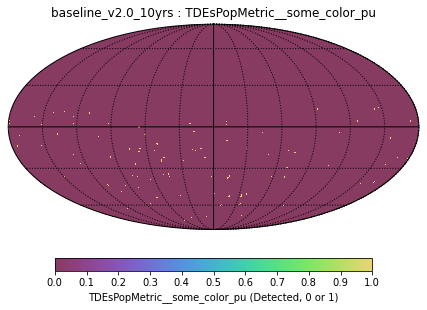

In [10]:
# If you don't want to try and plot N individual points, 
plotDict = {'reduceFunc': np.sum, 'nside': 64, 'colorMin': 0}
plotFunc = maf.plots.HealpixSkyMap()
ph = maf.plots.PlotHandler(outDir=outDir, figformat='png', thumbnail=False)
for k in bdict:
    if k.startswith('TDEs'):
        ph.setMetricBundles([bdict[k]])
        ph.plot(plotFunc=plotFunc, plotDicts=plotDict)

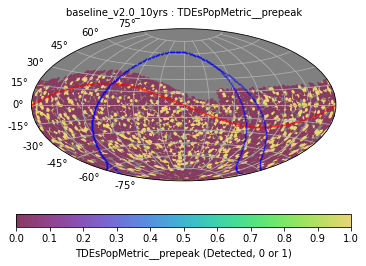

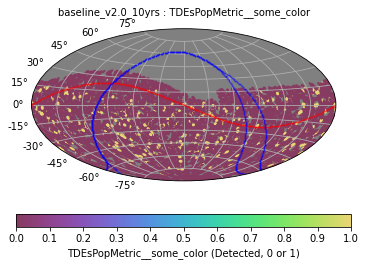

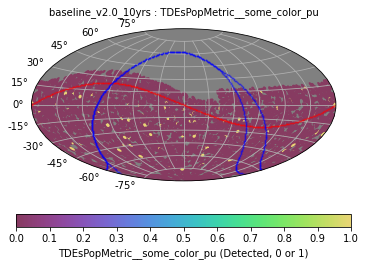

In [11]:
# If you do want to show each individual point - this is slower
plotFunc = maf.plots.BaseSkyMap()

ph = maf.plots.PlotHandler(outDir=outDir, figformat='png', thumbnail=False)
for k in bdict:
    if k.startswith('TDEs'):
        ph.setMetricBundles([bdict[k]])
        ph.plot(plotFunc=plotFunc)

In [12]:
for k in bdict:
    print(k, bdict[k].summaryValues)

tde {}
TDEsPopMetric__prepeak {'Total detected': 1869.0, 'Total lightcurves in footprint': 6939, 'Total lightcurves on sky': 10000, 'Fraction detected in footprint': 0.269347168179853, 'Fraction detected of total': 0.1869}
TDEsPopMetric__some_color {'Total detected': 507.0, 'Total lightcurves in footprint': 6939, 'Total lightcurves on sky': 10000, 'Fraction detected in footprint': 0.0730652831820147, 'Fraction detected of total': 0.0507}
TDEsPopMetric__some_color_pu {'Total detected': 104.0, 'Total lightcurves in footprint': 6939, 'Total lightcurves on sky': 10000, 'Fraction detected in footprint': 0.014987750396310708, 'Fraction detected of total': 0.0104}


In [13]:
pd.DataFrame([bdict[k].summaryValues for k in bdict.keys() if k.startswith('TDEs')], 
             index=[k.replace('_', ' ') for k in bdict if k.startswith('TDEs')])

,Total detected,Total lightcurves in footprint,Total lightcurves on sky,Fraction detected in footprint,Fraction detected of total
TDEsPopMetric prepeak,1869.0,6939,10000,0.269347,0.1869
TDEsPopMetric some color,507.0,6939,10000,0.073065,0.0507
TDEsPopMetric some color pu,104.0,6939,10000,0.014988,0.0104


The important number that serves as the strategy performance evaluation should be the *Fraction detected of total*.

## Run the metric measuring the quality of the light curves

*TdePopMetricQuality* measures how well are the light curves, which passed the above **some_color** and **some_color_pu** requirements, sampled in a certain time interval around the peak of the light curve. The default time interval is between $t_{min} = -30$ d and $t_{max} = 100$ d (where $t_{peak} = 0$ d). The metric counts the number of data points in this time interval for each light curve, and returns a ***score*** between 0 and 1.

In [14]:
metric = maf.mafContrib.TdePopMetricQuality(tmin=-30, tmax=100) 

# These summary metrics are now available as 'batches.lightcurveSummary' 
# (i.e. summaryMetrics = maf.lightcurveSummary())
summaryMetrics = [maf.MeanMetric(metricName='Light curve quality'), 
                  maf.FracAboveMetric(maskVal=0, cutoff=0.0001, metricName='Fraction detected of total')]

In [15]:
bundle = maf.MetricBundle(metric, slicer, None, runName=opsim, summaryMetrics=summaryMetrics)

In [16]:
outDir = 'test_tde_quality'
bdict = {'tde': bundle}
g = maf.MetricBundleGroup(bdict, opsdb, outDir)

In [17]:
g.runAll()

Querying database observations with no constraint for columns ['filter', 'rotSkyPos', 'fieldRA', 'night', 'observationStartMJD', 'fieldDec', 'fiveSigmaDepth'].
Found 2086980 visits
Running:  ['tde']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [18]:
bdict.keys()

dict_keys(['tde', 'TDEsPopMetricQuality__some_color_pnum', 'TDEsPopMetricQuality__some_color_pu_pnum'])

### Plot the outputs

The TDEsPopMetricQuality returns 0 if the light curve was not detected with **some_color**/**some_color_pu** requirements and 1, if the light curve was detected and had observations every other night. The score 0.5 means the light curve is, on average, observed every 4 nights. Scores higher than 1 are attributed to observations of TDEs in DDF (with more frequent temporal sampling).

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


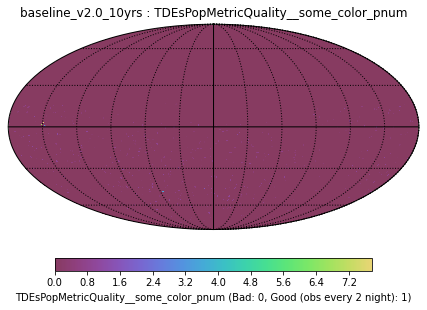

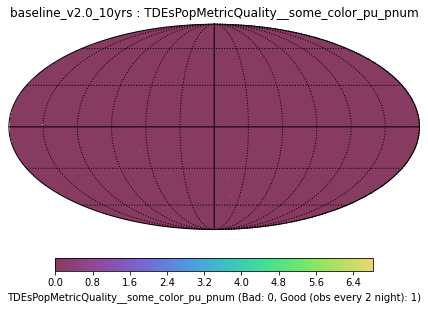

In [19]:
# If you don't want to try and plot N individual points, 
plotDict = {'reduceFunc': np.sum, 'nside': 64, 'colorMin': 0}
plotFunc = maf.plots.HealpixSkyMap()
ph = maf.plots.PlotHandler(outDir=outDir, figformat='png', thumbnail=False)
for k in bdict:
    if k.startswith('TDEs'):
        ph.setMetricBundles([bdict[k]])
        ph.plot(plotFunc=plotFunc, plotDicts=plotDict)

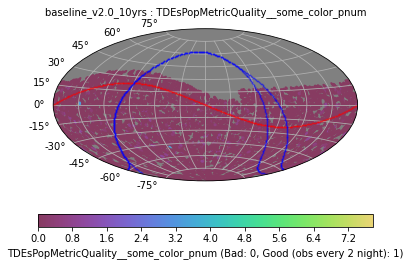

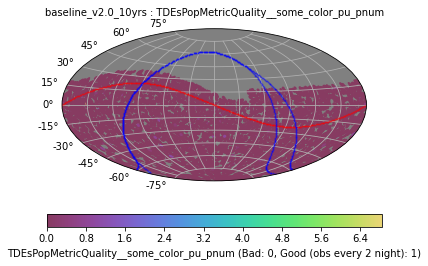

In [20]:
# If you do want to show each individual point - this is slower
plotFunc = maf.plots.BaseSkyMap()

ph = maf.plots.PlotHandler(outDir=outDir, figformat='png', thumbnail=False)
for k in bdict:
    if k.startswith('TDEs'):
        ph.setMetricBundles([bdict[k]])
        ph.plot(plotFunc=plotFunc)

In [21]:
for k in bdict:
    print(k, bdict[k].summaryValues)

tde {}
TDEsPopMetricQuality__some_color_pnum {'Light curve quality': 0.03538860620572683, 'Fraction detected of total': 0.0507}
TDEsPopMetricQuality__some_color_pu_pnum {'Light curve quality': 0.007677896393849702, 'Fraction detected of total': 0.0104}


In [22]:
pd.DataFrame([bdict[k].summaryValues for k in bdict.keys() if k.startswith('TDEs')], 
             index=[k.replace('_', ' ') for k in bdict if k.startswith('TDEs')])

,Light curve quality,Fraction detected of total
TDEsPopMetricQuality some color pnum,0.035389,0.0507
TDEsPopMetricQuality some color pu pnum,0.007678,0.0104


The important number that serves as the strategy performance evaluation should be the $\frac{\textit{Light curve quality}}{\textit{Fraction detected of total}}$. This tells us the average score all of the detected light curves have (per metric).

In [23]:
bdict_eval = bdict

for k in bdict_eval:
    if k.startswith('TDEs'):
        bdict_eval[k].summaryValues.update({'Light curve quality score': 
                                            bdict_eval[k].summaryValues['Light curve quality'] / 
                                            bdict_eval[k].summaryValues['Fraction detected of total']})

for k in bdict_eval:
    print(k, bdict_eval[k].summaryValues)

tde {}
TDEsPopMetricQuality__some_color_pnum {'Light curve quality': 0.03538860620572683, 'Fraction detected of total': 0.0507, 'Light curve quality score': 0.6980001224009236}
TDEsPopMetricQuality__some_color_pu_pnum {'Light curve quality': 0.007677896393849702, 'Fraction detected of total': 0.0104, 'Light curve quality score': 0.7382592686393945}


In [24]:
pd.DataFrame([bdict_eval[k].summaryValues for k in bdict_eval.keys() if k.startswith('TDEs')], 
             index=[k.replace('_', ' ') for k in bdict_eval if k.startswith('TDEs')])

,Light curve quality,Fraction detected of total,Light curve quality score
TDEsPopMetricQuality some color pnum,0.035389,0.0507,0.698000
TDEsPopMetricQuality some color pu pnum,0.007678,0.0104,0.738259


With baseline the detected light curves are sampled, on average, every 2.8 days in the time interval between 30 d before peak and 100 d after peak. The average time interval between subsequent days the light curve is observed is obtained from $2 \times (\textit{Light curve quality score})^{-1}$